<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/INSIST_PSF_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet
!pip install photutils --quiet

     |████████████████████████████████| 826 kB 18.5 MB/s 


# **GitHub**

In [ ]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 1130, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1130 (delta 1), reused 0 (delta 0), pack-reused 1124
Receiving objects: 100% (1130/1130), 165.89 MiB | 20.14 MiB/s, done.
Resolving deltas: 100% (613/613), done.


In [ ]:
cd /content/INSIST/

/content/INSIST


# **Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.table import Table

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib import colors as col
from astropy.wcs import WCS

from photutils import aperture as aper
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
from photutils.centroids import centroid_com, centroid_quadratic
from photutils.centroids import centroid_1dg, centroid_2dg

from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.integrate import trapz
import copy

import os
from time import perf_counter
import json
import requests

import mastcasjobs

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

sb.set_style('darkgrid')
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['figure.figsize']=(10,10)

# **DataFrame to Image**

In [ ]:
class PSF_gen():

  def __init__(self,name,df, cols, axis, mode,exp_time,fov):   
    """PSF Generator using Source catalog. Class which simulates the field 
    and creates image

    Parameters
    ----------
    name  : str, Catalog name or coordinates of the source

    df   : pd.DataFrame, Pandas dataframe with source catalog

    cols  :,dict dict object with column name conversions for ra,dec,mag_nuv. 
    Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

      'ra' (degrees)

      'dec' (degrees)

      'mag_nuv' (ABmag)
    axis     : str, 'Off' or "On", Secondary of the telescope.
    mode     : str, 'HCIPy' or 'Zeemax', PSF patch generation method
    exp_time : float, Exposure time in seconds 
    fov      : float, Field of View in degrees
    """
    self.name   = name
    self.axis   = axis
    self.mode   = mode
    self.cols   = cols
    self.fov    = fov
    self.radius = fov/2

    # Flags
    self.shot_noise = True
    self.QE         = True
    self.sky        = True
    self.PRNU       = True
    self.DC         = True
    self.DNFP       = True
    self.QN         = True

    # Parameters
    self.pixel_scale = 0.1
    self.params = {'shot_noise' : 'Gaussian',
                   'M_sky'      :  27.5,
                   'qe'         :  0.5,
                   'qe_sigma'   :  0.01,
                   'bias'       :  35,          # electrons
                   'bit_res'    :  14,        
                   'RN'         :  5,          # elec/pix
                   'PRNU_frac'  :  0.25/100,
                   'T'          :  223,        # K
                   'DFM'        :  1.424e-2,   # 14.24pA
                   'pixel_area' :  1e-6,       # 
                   'DN'         :  0.1/100,
                   'NF'         :  0       # electrons 
                   }
    self.response_func = ['qe.dat', 'filter.dat', 'coating.dat', 'dichroic.dat']
    self.full_well_capacity = 1.4e5           # electrons
    self.gain               = pow(2,self.params['bit_res'])/self.full_well_capacity
    self.M_sky_p     = self.params['M_sky'] - 2.5*np.log10(self.pixel_scale**2)

    self.exp_time    = exp_time  # seconds
    self.df          = df
    if self.df is not None or self.name is not None:
        self.init_df()
        self.init_psf_patch() 
    else:
        print("df cannot be None")

  def bandpass(self,response_funcs):
    x         = np.linspace(1000,9000,10000)
    y         = x*0 + 1.51e3*3631      #AB Mag

    y[0],y[-1] = 0,0
    outflux    = 1
    for file_name in response_funcs:
      filt_dat  = np.loadtxt(f'/content/INSIST/data/{file_name}')
      wav  = filt_dat[:,0]
      flux = filt_dat[:,1]
      flux/=flux.max()

      indices  = np.where( (wav>x[0]) & (wav<x[-1]))
      wav_new  = wav[indices]
      flux_new = flux[indices]
      
      wav_new  =  [x[0]] + list(wav_new) + [x[-1]]
      flux_new =  [0] + list(flux_new) + [0]

      wav_new = np.array(wav_new)
      flux_new = np.array(flux_new)

      filter_func = interp1d(wav_new,flux_new)

      flux_out = filter_func(x)

      outflux *= flux_out
      plt.plot(x,flux_out, label=f'{file_name[:-4]}')

    plt.plot(x,y,label = r'ZP($\lambda$)')
    plt.plot(x,outflux*y, label = 'Convloved Flux')
    plt.legend()
    plt.xlabel(r'$\AA$')
    plt.ylabel(r'Flux (x 3631 Jy)')

    int_flux   = trapz(outflux*y*x,x)/trapz(y*x,x)
    data       =  x,y, flux_out, outflux*y
    return data, int_flux

  def init_psf_patch(self, return_psf = False):

    #coeff = self.bandpass()

    self.zero_mag_s_on =  self.exp_time*1.51e3*3631*np.pi*(100/2)**2*(1500/2250)*0.8**6*0.95**2*0.68*0.83 # Photons

    self.zero_mag_s_off = self.exp_time*1.51e3*3631*np.pi*(100/2)**2*(1500/2250)*0.8**5*0.95**2*0.83      # Photons

    if self.mode == 'Zeemax':
      if self.axis =='On':
        image =  np.load('/content/INSIST/data/On_PSF_Zmax.npy')
        image /= image.sum()
        self.image_g_sub = image
        F_sky_p           = self.zero_mag_s_on*pow(10,-0.4*self.M_sky_p)
        self.sky_bag_flux = F_sky_p    
        self.zero_flux    = self.zero_mag_s_on 

      elif self.axis=='Off':
        image  = np.load('/content/INSIST/data/Off_PSF_Zmax.npy')
        image /= image.sum()
        self.image_g_sub  = image
        F_sky_p           = self.zero_mag_s_off*pow(10,-0.4*self.M_sky_p)
        self.sky_bag_flux = F_sky_p    
        self.zero_flux    = self.zero_mag_s_off 

    elif self.mode =='HCIPy':
      if self.axis =='On':
        image  = np.load('/content/INSIST/data/on_axis_hcipy.npy')
        image /= image.sum()
        self.image_g_sub =  image
        F_sky_p           = self.zero_mag_s_on*pow(10,-0.4*self.M_sky_p)
        self.sky_bag_flux = F_sky_p    
        self.zero_flux    = self.zero_mag_s_on  

      elif self.axis=='Off':
        image  = np.load('/content/INSIST/data/off_axis_hcipy.npy')
        image /= image.sum()
        self.image_g_sub  = image
        F_sky_p           = self.zero_mag_s_off*pow(10,-0.4*self.M_sky_p)
        self.sky_bag_flux = F_sky_p    
        self.zero_flux    = self.zero_mag_s_off 

    if return_psf:
      return image*self.zero_flux

  def mastQuery(self,request, json_return=False):
    """
    Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object

    Returns the text response or (if json_return=True) the json response
    """

    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)

    # make the query
    r = requests.post(url, data=dict(request=requestString))

    # raise exception on error
    r.raise_for_status()

    if json_return:
      return r.json()
    else:
      return r.text


  def resolve(self,name):
      """Get the RA and Dec for an object using the MAST name resolver
      
      Parameters
      ----------
      name (str): Name of object

      Returns RA, Dec tuple with position"""

      resolverRequest = {'service':'Mast.Name.Lookup',
                        'params':{'input':name,
                                  'format':'json'
                                  },
                        }
      resolvedObject = self.mastQuery(resolverRequest, json_return=True)
      # The resolver returns a variety of information about the resolved object, 
      # however for our purposes all we need are the RA and Dec
      try:
          objRa = resolvedObject['resolvedCoordinate'][0]['ra']
          objDec = resolvedObject['resolvedCoordinate'][0]['decl']
      except IndexError as e:
          raise ValueError("Unknown object '{}'".format(name))
      return (objRa, objDec)
  

  def init_df(self):     

    if self.name is not None and self.df is None:
      self.ra,self.dec = self.resolve(self.name)
      print("Input : MASTCasJobs")
      self.jobs = mastcasjobs.MastCasJobs(context="GALEX_Catalogs")
      self.query =   f"""SELECT ra,dec, mag_nuv,mag_fuv 
                          FROM
                          gcat_asc
                          WHERE
                          ra BETWEEN {self.ra} - {self.radius} AND {self.ra}   
                          + {self.radius}
                          AND 
                          dec BETWEEN {self.dec}- {self.radius} AND {self.dec} 
                          + {self.radius}
                      """
      print("Generating Dataframe")
      self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()

    else: 
      print("Input : Dataframe.")

      if self.cols is not None:
        self.df = self.df.rename(columns = self.cols) 
      self.ra   = (self.df['ra'].max()+self.df['ra'].min())/2
      self.dec  = (self.df['dec'].max()+self.df['dec'].min())/2
      
      self.df = self.df[ (self.df['ra']>self.ra - self.radius) & (self.df['ra']<self.ra + self.radius)]
      self.df = self.df[ (self.df['dec']>self.dec - self.radius) & (self.df['dec']<self.dec + self.radius)]

    self.name = f" RA : {np.round(self.ra,3)} degrees, Dec : {np.round(self.dec,3)} degrees"

  def init_image_array(self, return_img = False):
    """
    Creates a base image array for adding photons

    Parameters
    ----------
    return_img : bool, optional
        DESCRIPTION. The default is False.

    Returns
    -------
    numpy.ndarray
        if return_img is true return base image array
 

    """
    self.n_pix_sub  = self.image_g_sub.shape[0]
    del_ra  = self.df.ra.max()  - self.df.ra.min()
    del_dec = self.df.dec.max() - self.df.dec.min()
    
    n_pix_main = del_ra*3600/self.pixel_scale if del_ra>=del_dec else del_dec*3600/self.pixel_scale
  
    self.n_pix_main = int(n_pix_main) + 2*self.n_pix_sub

    if self.n_pix_main <=10000:
      self.image    = np.zeros((self.n_pix_main, self.n_pix_main))
      self.wcs      = self.create_wcs(self.n_pix_main,self.ra, self.dec, self.pixel_scale)
      
    else:
      print("FoV is too big.")

    if return_img:
      return self.image, self.wcs


  def create_wcs(self,npix,ra,dec,pixel_scale):
    """
    

    Parameters
    ----------
    npix : int
        number of pixels in image
    ra : float (degrees)
        right ascension of center of image.
    dec : float (degrees)
        declination of center of image.
    pixel_scale : floats
        arcsecs/pixel.

    Returns
    -------
    w : wcs object


    """ 
    w = WCS(naxis=2)
    w.wcs.crpix = [(npix-1)//2, (npix-1)//2]
    w.wcs.cdelt = np.array([-pixel_scale/3600, self.pixel_scale/3600])
    w.wcs.crval = [ra, dec]
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    return w

  def compute_coeff_arrays(self):
    """
    
    Computed coefficients based on input parameters
    Returns
    -------
    None.

    """

    n_pix = self.n_pix_main - self.n_pix_sub

    if self.QE:
      if self.params['qe']>0 and self.params['qe']<1:

        self.qe_array =  np.random.normal(loc=self.params['qe'], 
                                          scale=self.params['qe_sigma'],
                                          size=(n_pix, n_pix))
      else:
        print('QE should in the range (0,1]')
    else:
      self.qe_array = 1

    self.bias_array =  np.random.normal(loc=self.params['bias'], 
                                      scale=self.params['RN'],
                                      size=(n_pix, n_pix))
    if self.PRNU:

      self.PRNU_array =  np.random.normal(loc=0, 
                                        scale = self.params['PRNU_frac'],
                                        size=(n_pix, n_pix))
    if self.DC:
      self.DR = self.dark_current(self.params['T'], self.params['DFM'], 
                                  self.params['pixel_area'])

      self.DC_array = np.random.normal(loc = self.DR*self.exp_time, 
                                          scale = np.sqrt(self.DR*self.exp_time),
                                          size=(n_pix, n_pix))

    if self.DNFP and self.DC:
      self.DNFP_array =  np.random.lognormal(mean= 0, 
                                    sigma = self.exp_time*self.DR*self.params['DN'],
                                    size=(n_pix, n_pix))
      self.DC_array*=(1 + self.DNFP_array)

    if self.QN:
      self.QN_value = (self.full_well_capacity/(pow(2,self.params['bit_res'])
                                            *np.sqrt(12)))

      self.QN_array = self.QN_value*np.random.randint(-1,2,size = (n_pix,n_pix))
    else :
      self.QN_array = 0
    print("Coefficients Computed...")

  def dark_current(self,T, DFM, pixel_area):
    """
      

      Parameters
      ----------
      T : float
          Detector Temperature
      DFM : float
          Dark current figure of merit
      pixel_area : float
          Area of pixel

      Returns
      -------
      DR : float
         Dark current rate e/s/pixels

      """
    Kb  = 8.62e-5
    const	= 2.55741439581387e15

    EgT	= 1.1557 - (7.021e-4*T**2/(1108+T))
    DR	= const*pixel_area*(T**1.5)*DFM*np.exp(-EgT/(2*Kb*T))
    return DR
    
  def generate_photons(self, image,npix_m, npix_s,df):
    """
      This function creates PSFs based on ABmag  on a 
      small patch (2D array) of size n_pix_s*n_pix_s. 
      
      The patch with the PSF is then added to the image array of size 
      n_pix_m*n_pix_m using wcs object.

      Parameters
      ----------
      image : numpy.ndarray
         base image array for inserting star PSFs
      npix_m : int
          number of pixels (length) in base image
      npix_s : int
          number of pixels (length) in psf patch image
      df : pandas.dataframe
          Dataframe containing source list
          
    

      Returns
      -------
      image : numpy.ndarray
          Array with PSFs added based on df

      """
    if npix_s%2 ==0:
      patch_width_l = npix_s//2
      patch_width_r = npix_s//2

    else:
      patch_width_l = npix_s//2 
      patch_width_r = npix_s//2 +1

    for i, row in df.iterrows():

        c = SkyCoord(row['ra'],row['dec'],unit=u.deg)
        pix = self.wcs.world_to_array_index(c)
        ABmag = row['mag_nuv']

        flux  = self.zero_flux*10**(-ABmag/2.5)  # Photo-elec per second

        patch =  flux*self.image_g_sub

        x1 = pix[0] - patch_width_l
        x2 = pix[0] + patch_width_r
        y1 = pix[1] - patch_width_l
        y2 = pix[1] + patch_width_r

        image[ x1: x2, y1:y2 ] += patch

    image   = image[patch_width_l-1:-patch_width_r-1,patch_width_l-1:-patch_width_r-1]
    #if image.shape[0]>205:
      #image = image[patch_width_l-1:-patch_width_r-1,patch_width_l-1:-patch_width_r-1]

    return image

  def compute_shot_noise(self,array,type_ = 'Gaussian'):
    """

    Parameters
    ----------
    array : numpy.ndarray
        input array
    type_ : str, optional
         The default is 'gaussian'.

    Returns
    -------
    shot_noise : numpy.ndarray
         Return array with shot noise

    """

    if type(array) == np.float64 :
      n_pix = self.n_pix_main
    else :
      n_pix = array.shape[0]

    if type_ == 'Gaussian':
        shot_noise = np.random.normal(loc=array, scale=np.sqrt(array), size = (n_pix, n_pix))
    elif type_ =='Poisson':
        shot_noise = np.random.poisson(lam=array, size = (n_pix, n_pix)).astype(array.dtype)
    else:
      print('Invalid type')

    return shot_noise  


  def __call__(self,params = None,n_stack =1,stack_type = 'median'):
    """
    
     Parameters
     ----------
     params : dict, optional
     Dictionary contianing simulation parametes. The default is None.
     n_stack : int, optional
     Number of observations to be stacked. The default is 1.
     stack_type : str, optional
     Stacking method. The default is 'median'.
     
     
    Simulates field by taking dataframe as input by inserting PSF patches in 
    image array using WCS
     Returns
     -------
     numpy.ndarray
     Final image array after adding all layers of simulation
    
    """
    if params is not None:
      self.params.update(params)
      self.gain        = pow(2,self.params['bit_res'])/self.full_well_capacity
      self.M_sky_p     = self.params['M_sky'] - 2.5*np.log10(self.pixel_scale**2)
      self.init_psf_patch() 

    digital_stack = []

    self.init_image_array()
    self.compute_coeff_arrays()
    
    for i in range(n_stack):

      self.init_image_array()
      
      self.source_photons   = self.generate_photons(self.image,self.n_pix_main,self.n_pix_sub, self.df)
      
      if self.shot_noise:
         self.source_photons  = self.compute_shot_noise(self.source_photons 
                              ,type_ = self.params['shot_noise'])
         
      self.source_photoelec = self.source_photons*self.qe_array
         
      self.n_pix_main = self.source_photoelec.shape[0]

      if self.sky:
        self.sky_photoelec = self.compute_shot_noise(self.sky_bag_flux,
                                                     'Gaussian')*self.qe_array
        
        self.light_array = self.source_photoelec +  self.sky_photoelec
      else:
        self.light_array = self.source_photoelec

      if self.PRNU:
        self.light_array*=(1+self.PRNU_array)

      if self.DC:
        self.photoelec_array = self.light_array + self.DC_array
      else:
        self.photoelec_array  = self.light_array

      self.charge = self.photoelec_array + self.QN_array + self.params['NF'] + self.bias_array 
      
      self.digital = (self.charge*self.gain).astype(int)

      # Full well condition
      self.digital = np.where(self.digital>=pow(2, self.params['bit_res']),pow(2, self.params['bit_res']), self.digital)
      
      digital_stack.append(self.digital)
    
    digital_stack = np.array(digital_stack)
    if n_stack>1:
      if stack_type   == 'median':
        self.digital  = np.median(digital_stack, axis = 0)
      elif stack_type == 'mean':
        self.digital  = np.median(digital_stack, axis = 0)

    self.wcs = self.create_wcs(self.n_pix_main,self.ra,self.dec, self.pixel_scale)

    self.header = self.wcs.to_header()

    print("Image Simulation Complete...")
    
    return self.digital

In [ ]:
class PSF(PSF_gen):
  def __init__(self, name = None,df = None, cols = None, axis = 'On',mode = 'Zeemax',
               exp_time = 100, fov = 2):
      super().__init__(name = name, df=df, cols=cols, axis=axis, mode=mode,
                       exp_time = exp_time, fov = fov)
      """
      
      A class to visualize and analyze the simulated image
      
      Parameters
      ----------
      name  : str, Catalog name or coordinates of the source

      df   : pd.DataFrame, Pandas dataframe with source catalog

      cols  :,dict dict object with column name conversions for ra,dec,mag_nuv. 
      Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)
      axis     : str, 'Off' or "On", Secondary of the telescope.
      mode     : str, 'HCIPy' or 'Zeemax', PSF patch generation method
      exp_time : float, Exposure time in seconds 
      fov      : float, Field of View in degrees
      
     

      Returns
      -------
      None.

      """

  def __call__(self,params= None, n_stack =1, stack_type ='median'):
    super().__call__(params = params, n_stack = n_stack, stack_type = stack_type)
    """
    
    Performs PSF simulation and PSF Photometry
    
    TBW
    """
    
    
    if self.axis == 'Off':
      zero_p_flux = (3010478142.88666  + self.params['bias'])
    else:
      zero_p_flux = (1516505736.205873 + self.params['bias'])

    c          = SkyCoord(self.df['ra'], self.df['dec'],unit=u.deg)
    data       = self.digital.astype(float)
    wcs        = self.wcs
    pix        = wcs.world_to_array_index(c)

    position        = [(i,j) for i,j in zip(pix[1],pix[0])]

    aperture        = aper.CircularAperture(position, r=0.3/0.1)
    ap_pix          = np.count_nonzero(aperture.to_mask()[0])
    aperture_bag    = aper.CircularAnnulus(position, r_in = 0.3/0.1, r_out = 1/0.1)
    bag_mask        = aperture_bag.to_mask()[0]

    bag_flux        = bag_mask.get_values(data)

    # Median bag flux
    bag_flux_med    = np.sort(bag_flux)[len(bag_flux)//2]

    phot_table      = aperture_photometry(data, [aperture, aperture_bag])

    phot_table['sky_flux'] = ap_pix*bag_flux_med
    phot_table['flux']     = phot_table['aperture_sum_0'].value - phot_table['sky_flux'].value

    phot_table['flux_err'] = np.sqrt( phot_table['flux'].value  + phot_table['sky_flux'].value )
 
    phot_table['SNR']      = phot_table['flux'].value/ phot_table['flux_err'].value

    self.phot_table = phot_table
 


  def show_field(self,figsize=(10,10)):
    """
    Function for creating a scatter plot of sources within the FoV

    Returns
    -------
    fig, ax
    """
    if self.wcs is None :
      self.init_image_array()

    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
    ax.set_title(f" Requested Center : {self.name} \n FoV : {np.round(self.pixel_scale*(self.n_pix_main-2*self.n_pix_sub )/3600,3)} degrees | {len(self.df)} sources")
    ax.invert_xaxis()
    ax.set_xlabel('RA (Degrees)')
    ax.set_ylabel('Dec (Degrees)')
    return fig,ax

  def show_image(self, source = 'Digital', figsize = (15,10), download = False):
    """
    Function for plotting the simulated field with PSFs

    Returns
    -------
    fig, ax
    """

    fig = plt.figure(figsize = figsize)
    norm = None
    
    if source == 'Digital':
      data  = self.digital
      norm = col.LogNorm()
    elif source =='Charge':
      data  = self.charge
      norm = col.LogNorm()
    elif source == 'Sky':
      data = self.sky_photoelec
    elif source == 'DC':
      data = self.DC_array
    elif source == 'QE':
      data = self.qe_array
    elif source =='Bias':
      data = self.bias_array + self.DC_array 
    elif source == 'PRNU':
      data = self.PRNU_array
    elif source == 'DNFP':
      norm = col.LogNorm()
      data = self.DNFP_array
    elif source == 'QN':
      data = self.QN_array

    ax = fig.add_subplot(projection=self.wcs)
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth('3') 
    img = ax.imshow(data,cmap='jet' , norm = norm)
    plt.colorbar(img)
    ax.set_title(f'{source} \nRequested center : {self.name}')
    ax.grid(False)
    if download:
        fig.savefig(f"{source}.png", format = 'png')
    return fig,ax

  def show_hist(self, source = 'Digital',bins = None,figsize=(15,8)):
    fig, ax = plt.subplots(1,1,figsize=figsize)

    if source == 'Digital':
      data  = self.digital.ravel()
    elif source =='Charge':
      data  = self.charge.ravel()
      norm = col.LogNorm()
    elif source == 'Sky':
      data = self.sky_photoelec.ravel()
    elif source == 'DC':
      data = self.DC_array.ravel()
    elif source == 'QE':
      data = self.qe_array
    elif source =='Bias':
      data = (self.bias_array + self.DC_array).ravel()
    elif source == 'PRNU':
      data = self.PRNU_array.ravel()
    elif source == 'DNFP':
      data = self.DNFP_array.ravel()
    elif source == 'QN':
      data = self.QN_array.ravel()

    if bins is None:
      bins  = np.linspace(data.min(), data.max(), 20)
    ax.hist(data, bins = bins)
    ax.set_title(f'{source} histogram')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    return fig, ax

  def writeto(self,name,source = 'Digital', user_source = None):
    """
    Function for downloading a fits file of simulated field
    """
    if np.all(self.image) !=None :
      if user_source is not None and type(user_source)==np.ndarray:
        data = user_source
      elif source == 'Digital':
        data  = self.digital
        norm = col.LogNorm()
      elif source =='Charge':
        data  = self.charge
        norm = col.LogNorm()
      elif source == 'Sky':
        data = self.sky_photoelec
      elif source == 'DC':
        data = self.DC_array
      elif source == 'QE':
        data = self.qe_array
      elif source =='Bias':
        data = self.bias_array + self.DC_array 
      elif source == 'PRNU':
        data = self.PRNU_array
      elif source == 'DNFP':
        norm = col.LogNorm()
        data = self.DNFP_array
      elif source == 'QN':
        data = self.QN_array
    
      else:
        print(f"{source} is not a valid source")

      hdu = fits.PrimaryHDU(data, header = self.header)
      hdu.wcs = self.wcs
      hdul = fits.HDUList([hdu])
      hdul.writeto(f'{name}',overwrite= True)
    else:
      print("Generate PSF")

In [ ]:
ra      = [i*12/3600 for i in range(1,6)]  + [i*12/3600 +10/3600 for i in range(1,6)] + [i*12/3600 for i in range(1,6)]
dec     = [0*12/3600 for i in range(0,5)]  + [2*12/3600 for i in range(0,5)] + [4*12/3600 for i in range(0,5)]
mag_nuv = [0 +i for i in range(0,15)]
df      = pd.DataFrame(zip(ra,dec,mag_nuv), columns= ['ra', 'dec', 'mag_nuv'])

In [ ]:
ra  =     [0]
dec =     [0]
mag_nuv = [3]
df      = pd.DataFrame(zip(ra,dec,mag_nuv), columns= ['ra', 'dec', 'mag_nuv'])

In [ ]:
psf = PSF( df  = df, axis='Off',mode='HCIPy',exp_time = 1)

Input : Dataframe.


In [ ]:
psf()

Coefficients Computed...
Image Simulation Complete...


(<Figure size 1080x720 with 2 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7f5f42d88b90>)

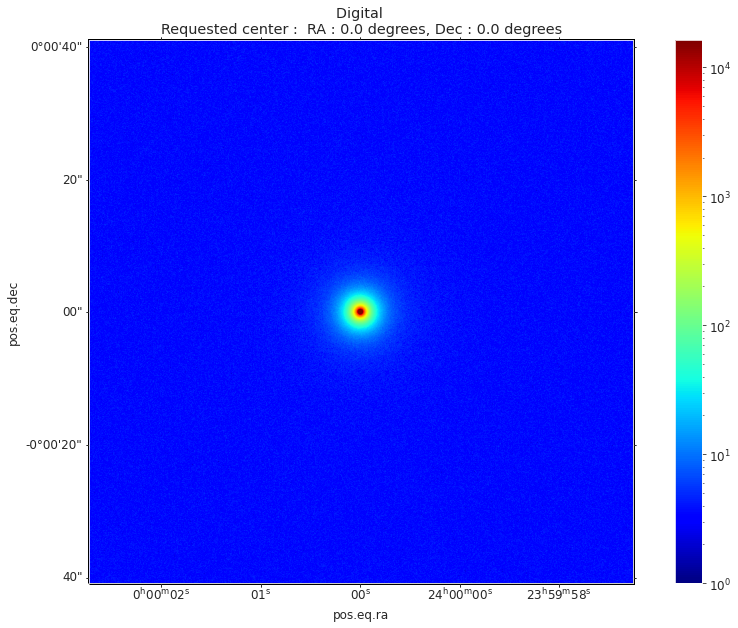

In [ ]:
psf.show_image()

In [ ]:
def bandpass(response_funcs):
    x         = np.linspace(1000,9000,10000)
    y         = x*0 + 1      #AB Mag

    y[0],y[-1] = 0,0
    outflux    = 1
    for file_name in response_funcs:
      filt_dat  = np.loadtxt(f'/content/INSIST/data/{file_name}')
      wav  = filt_dat[:,0]
      flux = filt_dat[:,1]
      flux/=flux.max()

      indices  = np.where( (wav>x[0]) & (wav<x[-1]))
      wav_new  = wav[indices]
      flux_new = flux[indices]
      
      wav_new  =  [x[0]] + list(wav_new) + [x[-1]]
      flux_new =  [0] + list(flux_new) + [0]

      wav_new = np.array(wav_new)
      flux_new = np.array(flux_new)

      filter_func = interp1d(wav_new,flux_new)

      flux_out = filter_func(x)

      outflux *= flux_out
      plt.plot(x,flux_out, label=f'{file_name[:-4]}')

    plt.plot(x,y,label = r'ZP($\lambda$)')
    plt.plot(x,outflux*y, label = 'Convloved Flux')
    plt.legend()
    plt.xlabel(r'$\AA$')
    plt.ylabel(r'Flux (x 3631 Jy)')

    int_flux   = trapz(outflux*x*y,x)/trapz(x*y,x)

    data       =  x,y, flux_out, outflux*y
    return data, int_flux

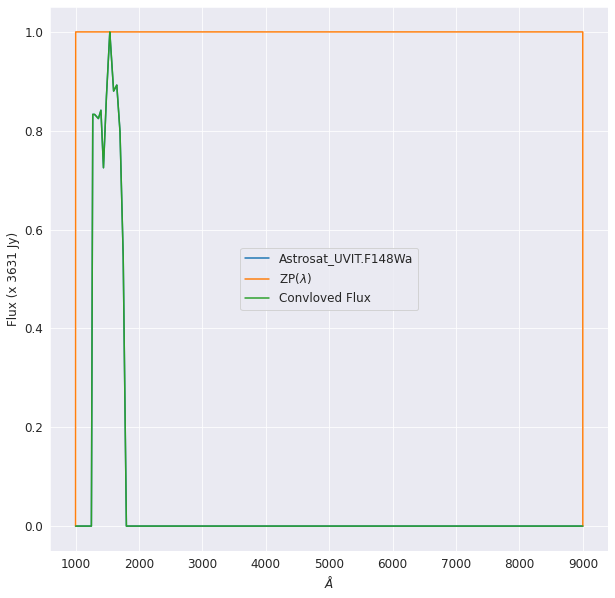

In [ ]:
data, int_flux = bandpass(['Astrosat_UVIT.F148Wa.dat'])

In [ ]:
int_flux

0.016104662896750315

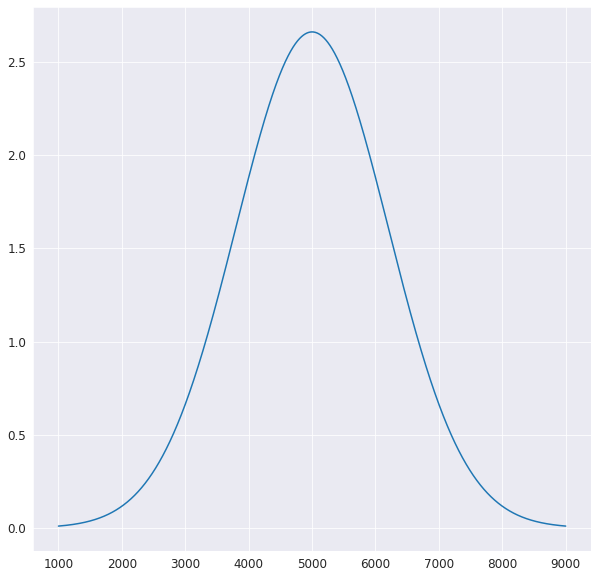

In [ ]:
x = np.linspace(1000,9000, 10000)
y = models.Gaussian1D(mean = 5000, stddev = 1200)(x)
y/=y.sum()
y*= 10000
plt.plot(x,y)

In [ ]:
data = []
data.append(x)
data.append(y)
data = np.array(data).T

In [ ]:
np.savetxt('data/qe.dat',data)

In [ ]:
int_flux

0.27283207084891836

# **Optics Simulations** 

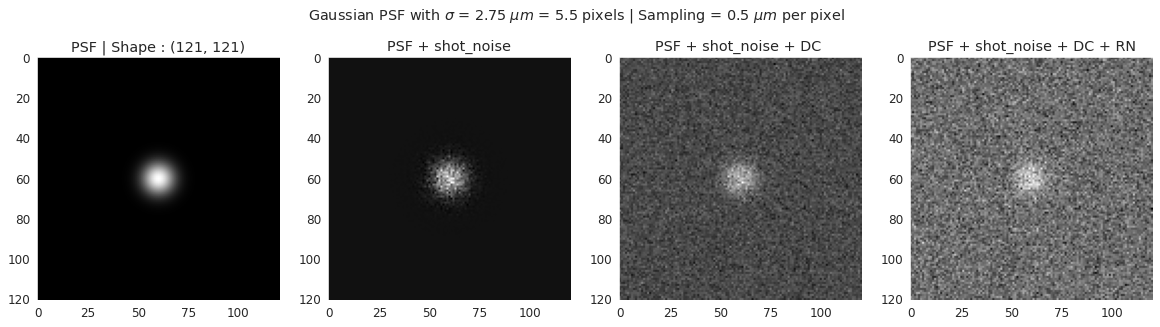

In [ ]:
n_pix = 121
y, x  = np.mgrid[0:(n_pix), 0:(n_pix)]
out = [] 
fig, ax = plt.subplots(1,4,figsize=(20,8))
for i in range(1):
  psf_model = models.Gaussian2D(15,len(x)//2,len(y)//2,5.5,5.5)
  psf       = psf_model(x,y)
  ax[0].imshow(psf,cmap = 'gray')
  ax[0].set_title(f'PSF | Shape : {psf.shape}')
  psf       = np.random.normal(psf,scale = np.sqrt(psf), size = [n_pix,n_pix])
  ax[1].imshow(psf,cmap = 'gray')
  ax[1].set_title('PSF + shot_noise')
  DC        = np.random.normal(5,scale = np.sqrt(5), size = [n_pix,n_pix])
  psf +=  DC
  ax[2].imshow(psf,cmap = 'gray')
  ax[2].set_title('PSF + shot_noise + DC ')
  RN        = np.random.normal(13,scale = np.sqrt(13), size = [n_pix,n_pix])
  psf+= RN
  ax[3].imshow(psf,cmap = 'gray')
  ax[3].set_title('PSF + shot_noise + DC + RN')
  psf_b     = psf.reshape(11,11, 11,11).sum(axis=(1,3))

  cen = centroid_quadratic(psf_b, fit_boxsize = 3)
  err = np.sqrt( (cen[0]-5)**2 + (cen[1]-5)**2)
  out.append([psf_model.amplitude.value,err])
  fig.suptitle(r'Gaussian PSF with $\sigma$ = 2.75 $\mu m$ = 5.5 pixels | Sampling = 0.5 $\mu m$ per pixel ',y = 0.8)
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)
out = np.array(out)

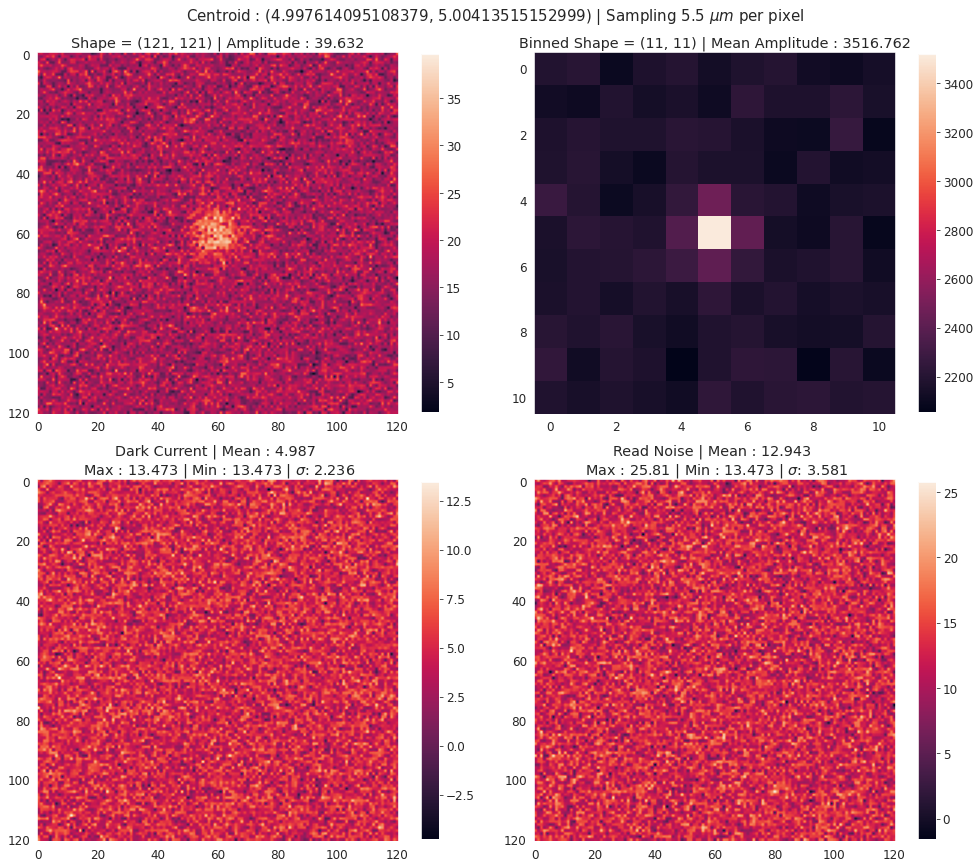

In [ ]:
fig,ax = plt.subplots(2,2, figsize = (17,15))
img = ax[0,0].imshow(psf)
plt.colorbar(img,ax = ax[0,0], shrink = 0.92)
ax[0,0].set_title(f'Shape = {psf.shape} | Amplitude : {round(psf.max(),3)}')

img = ax[0,1].imshow(psf_b)
plt.colorbar(img,ax = ax[0,1], shrink = 0.92)
ax[0,1].set_title(f'Binned Shape = {psf_b.shape} | Mean Amplitude : {round(psf_b.max(),3)}')


img = ax[1,0].imshow(DC)
plt.colorbar(img,ax = ax[1,0], shrink = 0.92)
ax[1,0].set_title(f'Dark Current | Mean : {round(DC.mean(),3)} \n Max : {round(DC.max(),3)} | Min : {round(DC.max(),3)}'+
                  r' | $\sigma$' + f': {round(DC.std(),3)}')


img = ax[1,1].imshow(RN)
ax[1,1].set_title(f'Read Noise | Mean : {round(RN.mean(),3)} \n Max : {round(RN.max(),3)} | Min : {round(DC.max(),3)}'+
                  r' | $\sigma$' + f': {round(RN.std(),3)}')
plt.colorbar(img,ax = ax[1,1], shrink = 0.92)
plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
fig.suptitle(f'Centroid : {tuple(cen)}' +r' | Sampling 5.5 $\mu m$ per pixel ', y=0.91, fontsize = 15)
ax[0,0].grid(False)
ax[0,1].grid(False)
ax[1,0].grid(False)
ax[1,1].grid(False)

Text(0.5, 1.0, 'Amplitude of source vs Centroid error')

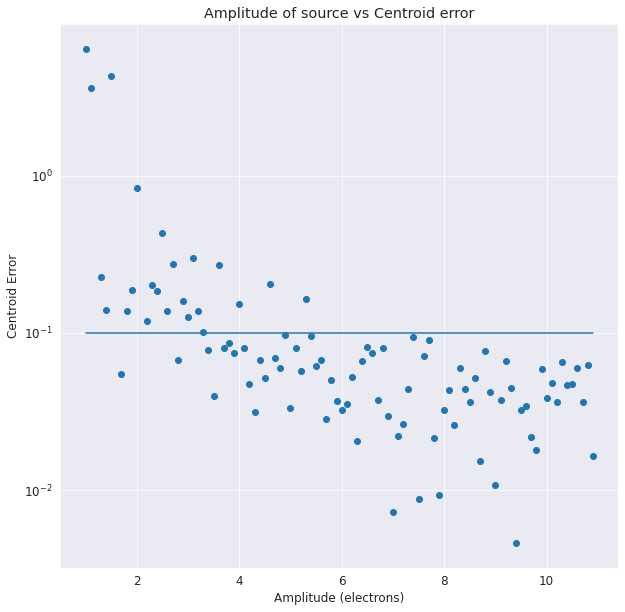

In [ ]:
plt.scatter(out[:,0],out[:,1])
plt.yscale('log')
x = np.linspace(out[:,0].min(), out[:,0].max(), 100)
y = x*0 + 0.1
plt.plot(x,y)
plt.xlabel('Amplitude (electrons)')
plt.ylabel('Centroid Error')
plt.title("Amplitude of source vs Centroid error")

In [ ]:
x

145209717.94377074

# **Plots**

In [ ]:
from matplotlib.ticker import LogLocator

Input : Dataframe.
Coefficients Computed...
Image Simulation Complete...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


Input : Dataframe.
Coefficients Computed...
Image Simulation Complete...
Input : Dataframe.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt


Coefficients Computed...
Image Simulation Complete...
Input : Dataframe.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


Coefficients Computed...
Image Simulation Complete...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in sqrt


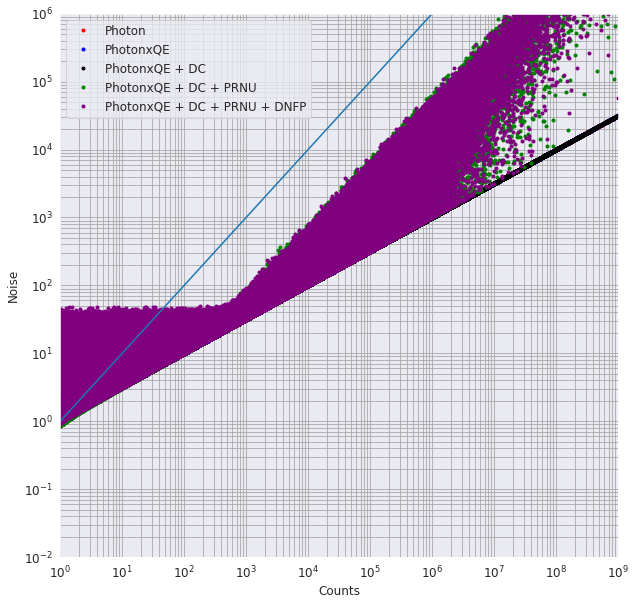

In [ ]:
fig, ax = plt.subplots(1,1)
exp_time = 600

psf = PSF( df  = df, axis='Off' ,mode='HCIPy',exp_time = exp_time)

psf.PRNU = False
psf.DNFP = False
psf.QN  = False
psf()

x = psf.source_photons.ravel()
y = np.sqrt(psf.source_photons).ravel()
x = np.where(x==0,np.nan,x)
ax.plot(x,y,'.', color ='red')

x = (psf.source_photoelec).ravel()
y = np.sqrt(psf.source_photoelec).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.plot(x,y,'.', color ='blue')

psf = PSF( df  = df, axis='Off',mode='HCIPy',exp_time = exp_time)
psf.PRNU = False
psf.DNFP = False
psf.QN   = False
params = {'RN': 3,'T' : 218, 'PRNU_frac' : 2/100,'DN': 0.1/100 }
psf(params = params)
x = (psf.photoelec_array-psf.DC_array).ravel()
y = np.sqrt(psf.photoelec_array + psf.DC_array**2 ).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.plot(x,y,'.', color ='black')

psf = PSF( df  = df, axis='Off',mode='HCIPy',exp_time = exp_time)
psf.PRNU = True
psf.DNFP = False
psf.QN   = False
psf(params = params)

x = (psf.photoelec_array-psf.DC_array).ravel()
y = np.sqrt(psf.photoelec_array + psf.DC_array**2+ (psf.photoelec_array*psf.PRNU_array)**2).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.plot(x,y,'.', color ='green')


psf = PSF( df  = df, axis='Off',mode='HCIPy',exp_time = exp_time)
psf.PRNU = True
psf.DNFP = True
psf.QN   = False
psf(params = params)

x = (psf.photoelec_array-psf.DC_array).ravel()
y = np.sqrt(psf.photoelec_array + psf.DC_array**2+ (psf.photoelec_array*psf.PRNU_array)**2 +  (psf.DC_array*psf.DNFP_array)**2).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.plot(x,y,'.', color ='purple')

x =  np.linspace(1,1e11)
y = x
plt.plot(x,y)


ax.set_xlabel('Counts')
ax.set_ylabel('Noise')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,1e9)

ax.xaxis.set_major_locator(LogLocator(numticks=15))
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10)))
ax.set_ylim(1e-2,1e6)
plt.grid(True, which="both",axis = 'both', ls="-", color='0.65')
plt.legend(['Photon','PhotonxQE', 'PhotonxQE + DC','PhotonxQE + DC + PRNU','PhotonxQE + DC + PRNU + DNFP']);

Input : Dataframe.
Coefficients Computed...
Image Simulation Complete...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


Input : Dataframe.
Coefficients Computed...
Image Simulation Complete...
Input : Dataframe.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt


Coefficients Computed...
Image Simulation Complete...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


Input : Dataframe.
Coefficients Computed...
Image Simulation Complete...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in sqrt


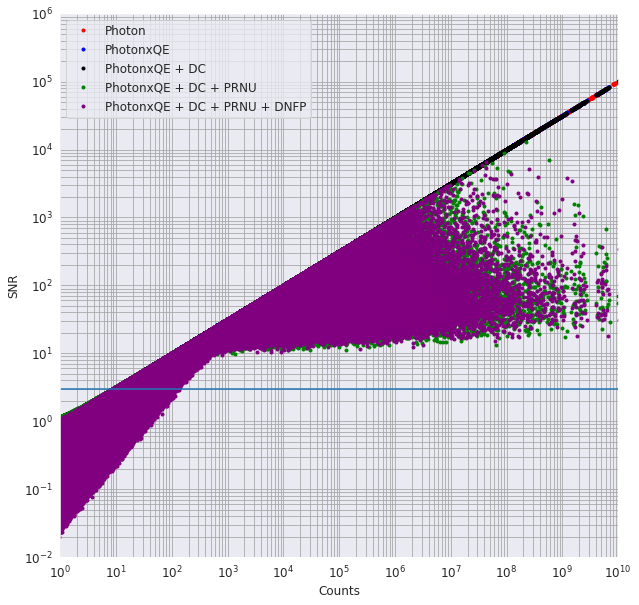

In [ ]:
fig, ax = plt.subplots(1,1)
exp_time = 600
params = {'RN': 3,'T' : 218, 'PRNU_frac' : 2/100,'DN': 0.1/100 }
psf = PSF( df  = df, axis='Off' ,mode='HCIPy',exp_time = exp_time)

psf.PRNU = False
psf.DNFP = False
psf.QN  = False
psf()

x = psf.source_photons.ravel()
y = x/np.sqrt(psf.source_photons).ravel()
x = np.where(x==0,np.nan,x)
ax.plot(x,y,'.', color ='red')

x = (psf.source_photoelec).ravel()
y = x/np.sqrt(psf.source_photoelec).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.plot(x,y,'.', color ='blue')

psf = PSF( df  = df, axis='Off',mode='HCIPy',exp_time = exp_time)
psf.PRNU = False
psf.DNFP = False
psf.QN   = False

psf(params = params)
x = (psf.photoelec_array-psf.DC_array).ravel()
y = x/np.sqrt(psf.photoelec_array + psf.DC_array**2 ).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.plot(x,y,'.', color ='black')

psf = PSF( df  = df, axis='Off',mode='HCIPy',exp_time = exp_time)
psf.PRNU = True
psf.DNFP = False
psf.QN   = False
psf(params = params)

x = (psf.photoelec_array-psf.DC_array).ravel()
y = x/np.sqrt(psf.photoelec_array + psf.DC_array**2+ (psf.photoelec_array*psf.PRNU_array)**2).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.plot(x,y,'.', color ='green')


psf = PSF( df  = df, axis='Off',mode='HCIPy',exp_time = exp_time)
psf.PRNU = True
psf.DNFP = True
psf.QN   = False
psf(params = params)

x = (psf.photoelec_array-psf.DC_array).ravel()
y = x/np.sqrt(psf.photoelec_array + psf.DC_array**2+ (psf.photoelec_array*psf.PRNU_array)**2 +  (psf.DC_array*psf.DNFP_array)**2).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.plot(x,y,'.', color ='purple')

x =  np.linspace(1,1e11)
y = x*0 +3
plt.plot(x,y)


ax.set_xlabel('Counts')
ax.set_ylabel('SNR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,1e10)

ax.xaxis.set_major_locator(LogLocator(numticks=15))
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10)))
ax.set_ylim(1e-2,1e6)
plt.grid(True, which="both",axis = 'both', ls="-", color='0.65')
plt.legend(['Photon','PhotonxQE', 'PhotonxQE + DC','PhotonxQE + DC + PRNU','PhotonxQE + DC + PRNU + DNFP']);

In [ ]:
DNs = []
exp_time = 1
params = {'RN': 3,'T' : 218, 'PRNU_frac' : 2/100,'DN': 0.1/100 }
for i in range(100):

  psf = PSF( df  = df, axis='Off',mode='HCIPy',exp_time = exp_time)
  psf(params = params)
  DNs.append(psf.digital)
DNs = np.array(DNs)

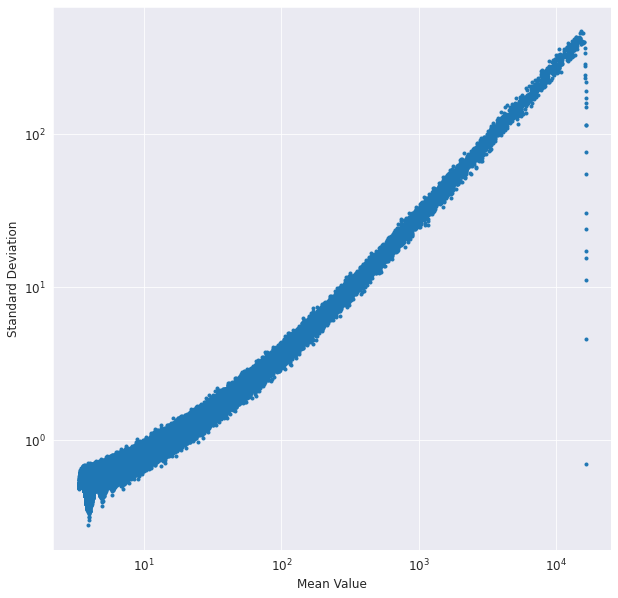

In [ ]:
x = DNs.mean(axis = 0).ravel()
y = DNs.std(axis = 0).ravel()
plt.plot(x,y,'.')
plt.xlabel('Mean Value')
plt.ylabel('Standard Deviation')
plt.xscale('log')
plt.yscale('log')


In [ ]:
med_img = np.median(DNs, axis = 0)

(0.0, 100.0)

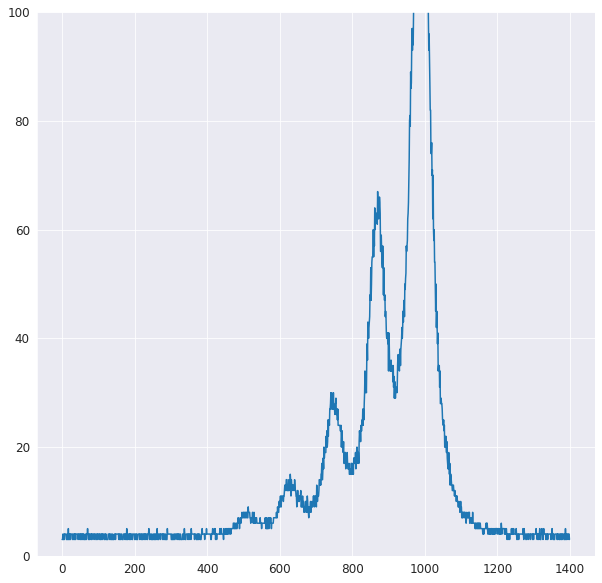

In [ ]:
plt.plot(DNs[0][420,:])
plt.ylim(0,100)

(0.0, 100.0)

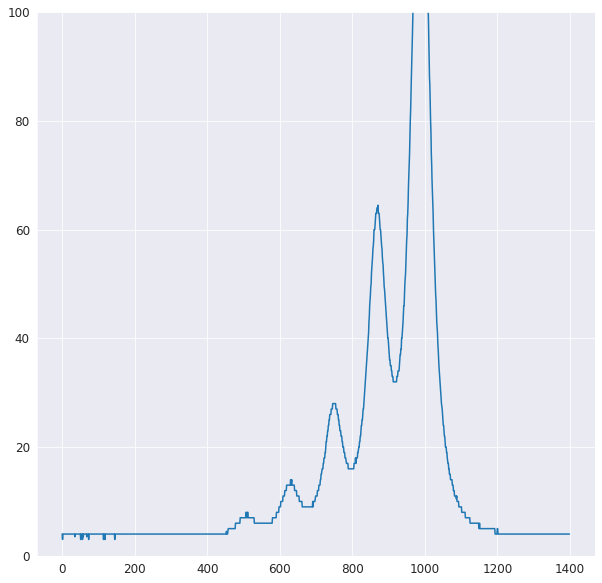

In [ ]:
plt.plot(med_img[420,:])
plt.ylim(0,100)

Text(0.5, 0, 'Y')

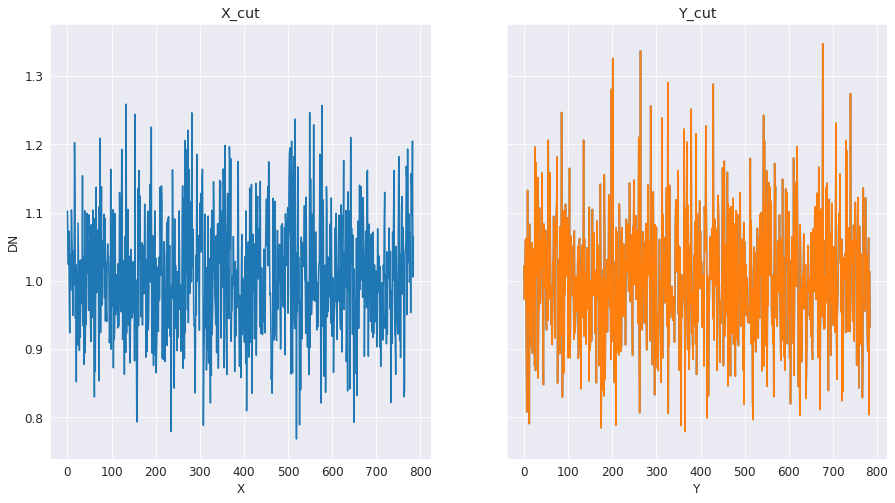

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(psf.DNFP_array[:,392])
ax[0].set_title('X_cut')
ax[0].set_xlabel('X')
ax[0].set_ylabel('DN')
ax[1].plot(psf.DNFP_array[392,:])
ax[1].set_title('Y_cut')
ax[1].set_xlabel('Y')

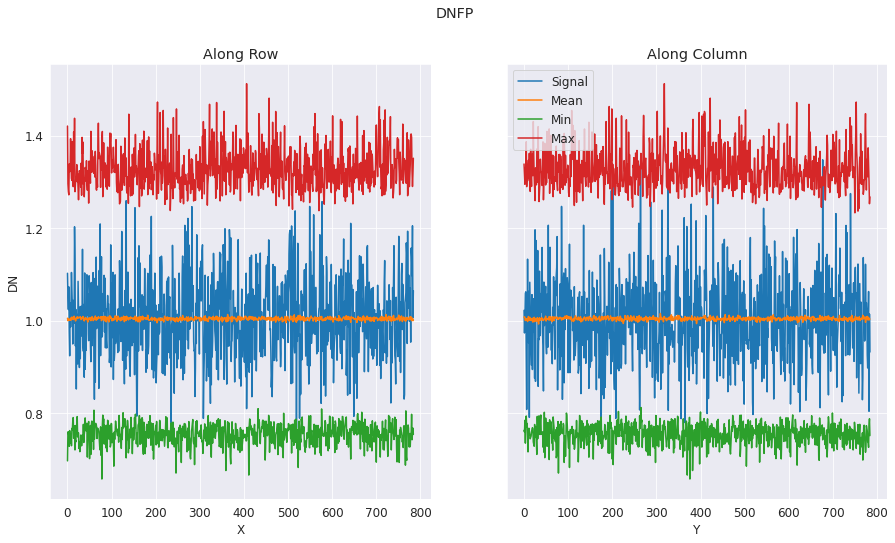

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(psf.DNFP_array[:,392])
ax[0].plot(psf.DNFP_array.mean(axis = 0))
ax[0].plot(psf.DNFP_array.min(axis = 0))
ax[0].plot(psf.DNFP_array.max(axis = 0))
ax[0].set_title('Along Row')
ax[0].set_xlabel('X')
ax[0].set_ylabel('DN')
ax[1].plot(psf.DNFP_array[392,:])
ax[1].plot(psf.DNFP_array.mean(axis = 1))
ax[1].plot(psf.DNFP_array.min(axis = 1))
ax[1].plot(psf.DNFP_array.max(axis = 1))
ax[1].set_title('Along Column')
ax[1].set_xlabel('Y')
fig.suptitle('DNFP')
plt.legend(['Signal', 'Mean','Min','Max'])

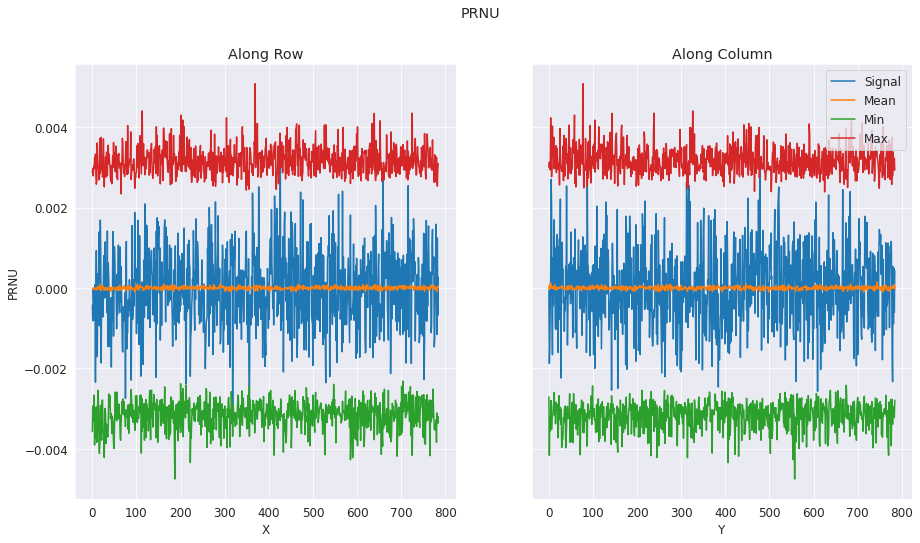

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(psf.PRNU_array[:,392])
ax[0].plot(psf.PRNU_array.mean(axis = 0))
ax[0].plot(psf.PRNU_array.min(axis = 0))
ax[0].plot(psf.PRNU_array.max(axis = 0))
ax[0].set_title('Along Row')
ax[0].set_xlabel('X')
ax[0].set_ylabel('PRNU')
ax[1].plot(psf.PRNU_array[392,:])
ax[1].plot(psf.PRNU_array.mean(axis = 1))
ax[1].plot(psf.PRNU_array.min(axis = 1))
ax[1].plot(psf.PRNU_array.max(axis = 1))
ax[1].set_title('Along Column')
ax[1].set_xlabel('Y')
fig.suptitle('PRNU')
plt.legend(['Signal', 'Mean','Min','Max'])

In [ ]:
df_new = df

In [ ]:
t = []
exp_time = 1
params = {'RN': 3,'T' : 218, 'PRNU_frac' : 2/100,'DN': 0.1/100 }
for i in range(100):
  start = perf_counter()
  psf = PSF( df  = df_new, axis='Off',mode='HCIPy',exp_time = exp_time)
  psf(params = params)
  time = perf_counter() - start
  t.append(time)
  df_new = df_new.append(df)
  
DNs = np.array(DNs)

Text(0.5, 1.0, 'Simulation time for (820, 820)')

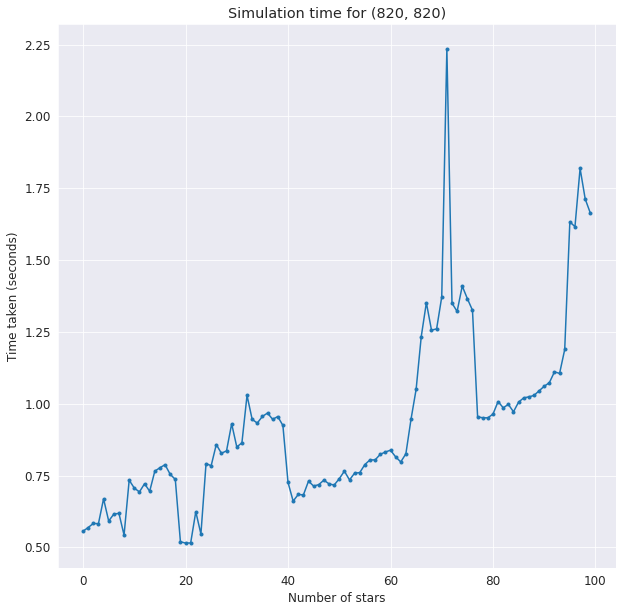

In [ ]:
plt.plot(t,'.-')
plt.xlabel('Number of stars')
plt.ylabel('Time taken (seconds)')
plt.title(f'Simulation time for {psf.digital.shape}')

# **Pyxel**

In [ ]:
with open("/content/INSIST/data/exposure_on.yaml",'r') as f:
  dat = yaml.load(f)

In [ ]:
dat['pipeline']['photon_generation'][0]['arguments']['image_file'] = 'data/source.fits'

In [ ]:
dat['pipeline']['optics'][0]['arguments']['fov_arcsec'] = 20.5

In [ ]:
dat['cmos_detector']['geometry']['row']= psf.photon_array.shape[0]
dat['cmos_detector']['geometry']['col']= psf.photon_array.shape[1]
dat['cmos_detector']['geometry']['total_thickness'] = 10

In [ ]:
with open("/content/INSIST/data/exposure_on.yaml", 'w') as out:
  yaml.dump(dat,out)

In [ ]:
config = pyxel.load("/content/INSIST/data/exposure_on.yaml")
exposure = config.exposure  # class Single
detector = config.cmos_detector  # class CMOS
pipeline = config.pipeline  # class DetectionPipeline

In [ ]:
result = pyxel.exposure_mode(exposure=exposure, detector=detector, pipeline=pipeline)
result

/usr/local/lib/python3.7/dist-packages/pyxel/data_structure/photon.py:61: UserWarning: Trying to set negative values in the Photon array! Negative values clipped to 0.
  "Trying to set negative values in the Photon array! Negative values clipped to 0."


Cosmix:   0%|          | 0/100 [00:00<?, ? particle/s]

<xarray.Dataset>
Dimensions:       (readout_time: 1, x: 3785, y: 3785)
Coordinates:
  * readout_time  (readout_time) int64 1
  * y             (y) int64 0 1 2 3 4 5 6 ... 3778 3779 3780 3781 3782 3783 3784
  * x             (x) int64 0 1 2 3 4 5 6 ... 3778 3779 3780 3781 3782 3783 3784
Data variables:
    image         (readout_time, y, x) uint32 3 1 1 3 5 5 6 ... 9 6 7 11 6 10 8
    signal        (readout_time, y, x) float64 0.0003276 0.0001241 ... 0.001178
    pixel         (readout_time, y, x) float64 1.092 0.4137 ... 5.053 3.928

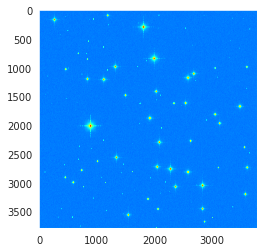

In [ ]:
plt.imshow(result.pixel.data[0], cmap = 'jet', norm = col.LogNorm());

In [ ]:
result.pixel.data[0].max()

100000.0

In [ ]:
hdu = fits.PrimaryHDU(result.pixel.data[0])
hdul = fits.HDUList(hdu)
hdul.writeto('pyxel.fits')